# Aqui, insira um título

In [1]:
import pickle
import xgboost
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook, tqdm
from skopt import forest_minimize
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from multiprocessing import cpu_count

from base import * 
from experimental import * 
import json
from tqdm import tqdm


In [2]:
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)


In [3]:
n_jobs = cpu_count()

In [4]:
inp_path = '../data/'
metadata = pd.read_csv(inp_path + 'metadata.csv')
test = pd.read_csv(inp_path + 'test.csv').set_index('id')
train = pd.read_csv(inp_path + 'train.csv').set_index('id')
#train = train.sample(frac=1, random_state=0).reset_index(drop=True)  # shuffling dataset
sub = pd.read_csv(inp_path + 'submission_sample.csv')

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
def model_instance(parameters):

    # Parametros de classificação
    classifier_parameters = dict(
        map(
            lambda x: (x["parameter"], x["estimate"]),
            filter(lambda x: x["description"] == "classifier", parameters),
        )
    )

    # Parâmetros de preprocessmento
    params = pd.DataFrame(parameters).set_index("parameter").to_dict(orient="index")
    
    min_correlation = params["min_correlation"]["estimate"]
    z_score = params["z_score"]["estimate"]
    z_score_range = (-z_score, z_score)
    polynomial_degree = 1
    
    estimator = RandomForestClassifier(n_jobs=n_jobs, random_state=42)

    model = Model(
        estimator,
        classifier_params=classifier_parameters,
        min_correlation=min_correlation,
        z_score_range=z_score_range,
        polynomial_degree=polynomial_degree,
    )
    
    return model

In [7]:
def score_function(X, y, parameters):

#     # Parametros de classificação
#     classifier_parameters = dict(
#         map(
#             lambda x: (x["parameter"], x["estimate"]),
#             filter(lambda x: x["description"] == "classifier", parameters),
#         )
#     )

#     # Parâmetros de preprocessmento
#     params = pd.DataFrame(parameters).set_index("parameter").to_dict(orient="index")
    
#     min_correlation = params["min_correlation"]["estimate"]
#     z_score = params["z_score"]["estimate"]
#     z_score_range = (-z_score, z_score)
#     polynomial_degree = 1
    
#     estimator = XGBClassifier(n_jobs=n_jobs, random_state=42, eval_metric="logloss")

#     model = Model(
#         estimator,
#         classifier_params=classifier_parameters,
#         min_correlation=min_correlation,
#         z_score_range=z_score_range,
#         polynomial_degree=polynomial_degree,
#     )
    model = model_instance(parameters)
    cv_score = -model.cross_validate_score(X, y)

    return  cv_score

In [8]:
# %run experimental.py


    
# new_parameters(parameters)

In [ ]:
%%time
n_iter = 100
n_repetitions = 1


for i in range(n_repetitions):

    # Importando Parâmetros
    with open(r"parameters_opt.json", "r") as read_file:
        parameters = json.load(read_file)

    X = train.drop("y", 1)
    y = train["y"]

    x = parameters
    p = score_function(X, y, x)

    xmax = x
    pmax = p

    for i in range(n_iter):

        print( f"\n{i}\t>>> param:",[elem["estimate"] for elem in x])
        print("\t>>> score:", np.round(p, 7))
        print("\t>>> score-max:", np.round(pmax, 7))

        x0 = new_parameters(x)
        p0 = score_function(X, y, x0)

        A = min(1, p0 / p)
        u = np.random.random()

        if u <= A:
            x = x0
            p = p0

        if p > pmax:
            xmax = x0
            pmax = p0

    print( f"\n{i}\t>>> param:",[elem["estimate"] for elem in xmax])
    print("\t>>> score:", np.round(pmax, 7))
    print("###################################################################")
    with open("parameters_opt.json", "w") as file:
        json.dump(xmax, file, indent=2, cls=NpEncoder)


0	>>> param: [83, 'entropy', 13, 6, 4, 0.0, 0.9886724585380823, 3.813401418088005, 0.04565309006023782]
	>>> score: 0.6540584
	>>> score-max: 0.6540584

1	>>> param: [74, 'entropy', 13, 6, 3, 0.0, 0.9569212455318752, 3.740119646776995, 0.04523237277700162]
	>>> score: 0.64818
	>>> score-max: 0.6540584

2	>>> param: [70, 'entropy', 13, 6, 4, 0.040265405348648406, 0.9355339856207294, 3.6312224706596696, 0.04745098313757863]
	>>> score: 0.6163152
	>>> score-max: 0.6540584

3	>>> param: [65, 'entropy', 14, 5, 4, 0.0018683257126553207, 0.9583923305891245, 3.559636734714841, 0.044947176296360754]
	>>> score: 0.6469505
	>>> score-max: 0.6540584

4	>>> param: [67, 'entropy', 13, 6, 4, 0.049869006318700206, 0.9642045746115067, 3.6605773875641066, 0.04231518288737691]
	>>> score: 0.6138929
	>>> score-max: 0.6540584

5	>>> param: [66, 'entropy', 11, 5, 4, 0.031178103239431168, 0.9496820479482367, 3.715252681297327, 0.04106896489524929]
	>>> score: 0.6355605
	>>> score-max: 0.6540584

6	>>> param

In [65]:
def neighbor_x(parameters, epsilon):

    new_parameters = deepcopy(parameters)

    for elem in new_parameters:
        if elem["type"] == "real":
            elem["estimate"] = elem["estimate"] + epsilon * np.diff(elem["range"])[0]

        elif elem["type"] == "integer":
            elem["estimate"] = elem["estimate"] + 1

    return new_parameters


In [67]:
parameters_neighbor = neighbor_x(parameters, 0.01)

0.6540584395785568

In [114]:
grad_vector = {}

In [86]:
[elem['parameter'] for elem in parameters]

['n_estimators',
 'criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'z_score',
 'min_correlation']

In [ ]:
%%time

par = "min_samples_leaf"
epsilon = 0.01
alpha = 0.05
grad_vector = {}

for i in range(10):

    print(score_function(X, y, parameters))

    final_parameters = deepcopy(parameters)

    for par in [elem["parameter"] for elem in parameters]:

        par_dict = list(filter(lambda x: x["parameter"] == par, parameters))[0]

        ind = np.argwhere(np.array([elem["parameter"] for elem in parameters]) == par)[0][0]

        new_parameters = deepcopy(parameters)

        if new_parameters[ind]["type"] == "integer":

            delta = 1

            new_parameters[ind]["estimate"] = new_parameters[0]["estimate"] + delta

            s1 = score_function(X, y, parameters)

            s2 = score_function(X, y, new_parameters)

            grad = int((s2 - s1) / np.abs(s2 - s1))

            final_parameters[ind]["estimate"] = np.clip(
                final_parameters[ind]["estimate"] + grad, *final_parameters[ind]["range"]
            )

        elif new_parameters[ind]["type"] == "real":

            try:
                delta = epsilon * np.diff(new_parameters[ind]["range"])[0]

                new_parameters[ind]["estimate"] = new_parameters[ind]["estimate"] + delta

                s1 = score_function(X, y, parameters)

                s2 = score_function(X, y, new_parameters)

                grad = alpha * np.diff(new_parameters[ind]["range"])[0] * (s2 - s1) / delta
            except:
                grad = 0

            final_parameters[ind]["estimate"] = np.clip(
                final_parameters[ind]["estimate"] + grad, *final_parameters[ind]["range"]
            )
            
    parameters = final_parameters


0.6540584395785568
0.6488070740566074
0.6518552772353532
0.6545192017672896
0.6481275978083096
0.6545192017672896
0.6481275978083096
0.6545192017672896


0.6540584395785568

In [155]:
score_function(X, y, final_parameters)

0.6378155281580116

In [126]:
new_parameters

[{'parameter': 'n_estimators',
  'type': 'integer',
  'estimate': 83,
  'range': [50, 150],
  'step': 10,
  'description': 'classifier'},
 {'parameter': 'criterion',
  'type': 'categorical',
  'estimate': 'entropy',
  'range': ['entropy'],
  'step': '',
  'description': 'classifier'},
 {'parameter': 'max_depth',
  'type': 'integer',
  'estimate': 13,
  'range': [10, 20],
  'step': 2,
  'description': 'classifier'},
 {'parameter': 'min_samples_split',
  'type': 'integer',
  'estimate': 6,
  'range': [2, 6],
  'step': 1,
  'description': 'classifier'},
 {'parameter': 'min_samples_leaf',
  'type': 'integer',
  'estimate': 4,
  'range': [1, 4],
  'step': 1,
  'description': 'classifier'},
 {'parameter': 'min_weight_fraction_leaf',
  'type': 'real',
  'estimate': 84.0,
  'range': [0.0, 0.5],
  'step': 0.05,
  'description': 'classifier'},
 {'parameter': 'max_features',
  'type': 'real',
  'estimate': 0.9886724585380823,
  'range': [0.5, 1.0],
  'step': 0.05,
  'description': 'classifier'},


In [80]:
new_parameters

[{'parameter': 'n_estimators',
  'type': 'integer',
  'estimate': 84,
  'range': [50, 150],
  'step': 10,
  'description': 'classifier'},
 {'parameter': 'criterion',
  'type': 'categorical',
  'estimate': 'entropy',
  'range': ['entropy'],
  'step': '',
  'description': 'classifier'},
 {'parameter': 'max_depth',
  'type': 'integer',
  'estimate': 13,
  'range': [10, 20],
  'step': 2,
  'description': 'classifier'},
 {'parameter': 'min_samples_split',
  'type': 'integer',
  'estimate': 6,
  'range': [2, 6],
  'step': 1,
  'description': 'classifier'},
 {'parameter': 'min_samples_leaf',
  'type': 'integer',
  'estimate': 4,
  'range': [1, 4],
  'step': 1,
  'description': 'classifier'},
 {'parameter': 'min_weight_fraction_leaf',
  'type': 'real',
  'estimate': 0.0,
  'range': [0.0, 0.5],
  'step': 0.05,
  'description': 'classifier'},
 {'parameter': 'max_features',
  'type': 'real',
  'estimate': 0.9886724585380823,
  'range': [0.5, 1.0],
  'step': 0.05,
  'description': 'classifier'},
 

In [74]:
parameters

[{'parameter': 'n_estimators',
  'type': 'integer',
  'estimate': 83,
  'range': [50, 150],
  'step': 10,
  'description': 'classifier'},
 {'parameter': 'criterion',
  'type': 'categorical',
  'estimate': 'entropy',
  'range': ['entropy'],
  'step': '',
  'description': 'classifier'},
 {'parameter': 'max_depth',
  'type': 'integer',
  'estimate': 13,
  'range': [10, 20],
  'step': 2,
  'description': 'classifier'},
 {'parameter': 'min_samples_split',
  'type': 'integer',
  'estimate': 6,
  'range': [2, 6],
  'step': 1,
  'description': 'classifier'},
 {'parameter': 'min_samples_leaf',
  'type': 'integer',
  'estimate': 4,
  'range': [1, 4],
  'step': 1,
  'description': 'classifier'},
 {'parameter': 'min_weight_fraction_leaf',
  'type': 'real',
  'estimate': 0.0,
  'range': [0.0, 0.5],
  'step': 0.05,
  'description': 'classifier'},
 {'parameter': 'max_features',
  'type': 'real',
  'estimate': 0.9886724585380823,
  'range': [0.5, 1.0],
  'step': 0.05,
  'description': 'classifier'},
 

In [17]:

# Your codes .... 


best = [5.7600e-02 1.4700e+02 5.0000e+00 2.0000e+00 3.8630e-01 2.1940e-01
 7.1780e-01 4.4040e-01 6.5700e-01 3.0000e+00 3.0000e+00 2.6304e+00
 0.0000e+00]

In [15]:
# Importando Parâmetros
with open(r"parameters_opt.json", "r") as read_file:
    parameters = json.load(read_file)

X = train.drop("y", 1)
y = train["y"]
    
model = model_instance(parameters)

# model.fit(X,y)

In [16]:
model.cross_validate_score(X,y)

-0.6424393785551729

In [34]:
test

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,5,126,1353,28956,743,1289,27,-999,1,33,4530,914,991,19,1,3,3,3,1155,19,1031,5,3,2,3,7,0,25,4,1,0,11,2,62,413,27,0,0,4,6,3,24,3,1,0,0,0,0,0,0,0,44,1,1,0.217528,0.272,0.367742,0.062900,0.201839,0.353965,0.166641,0.049108,0.986882,0.016683,-999.0,-999.0,0.176471,0.253676
2,6,126,1446,7803,5151,935,35,-999,3,63,8731,1341,2033,26,58,58,22,5,1299,26,773,5,3,1,2,1,0,25,4,0,1,6,5,58,692,21,15,8,4,0,1,30,0,1,0,0,0,0,0,0,0,13,1,1,0.221968,0.853,0.053763,0.177047,0.072127,0.074555,0.217009,0.144403,0.892028,0.038323,-999.0,-999.0,0.147059,0.099265
4,5,44,243,4325,1109,1903,33,24,1,63,10131,914,1503,24,60,61,23,5,1294,24,1562,5,4,1,0,1,0,26,5,2,0,17,0,12,553,0,18,0,4,10,3,26,14,1,0,0,0,0,0,0,0,36,1,1,0.213224,0.632,0.101075,0.210879,0.324770,0.384992,0.330680,0.072864,0.930373,0.021052,-999.0,-999.0,0.294118,0.136029
7,4,53,419,743,7750,183,35,-999,3,14,636,5879,146,26,22,22,10,4,811,26,152,5,3,2,4,4,0,24,4,2,0,12,5,38,662,28,1,0,4,9,3,28,7,1,0,0,0,0,0,1,0,13,1,1,0.205044,0.117,0.935484,0.007068,0.131070,-999.000000,0.244936,0.158088,0.986882,0.022649,-999.0,-999.0,0.294118,0.220588
15,4,126,1863,22693,5625,965,9,-999,3,63,24967,4427,772,5,73,73,29,5,595,5,796,0,1,0,1,7,0,11,2,1,0,21,3,18,546,0,1,0,4,6,3,28,8,1,0,0,0,0,1,0,0,51,1,1,0.203750,0.079,0.967742,0.024989,0.225166,0.059940,0.252794,0.080405,0.944501,0.021806,-999.0,-999.0,0.352941,0.113971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35297,4,126,1460,13335,9048,620,35,27,3,63,13567,2617,572,26,37,35,11,4,1573,26,592,5,3,2,1,1,0,24,4,1,0,21,6,42,332,21,20,9,1,11,3,25,13,1,0,0,0,0,0,0,0,34,2,2,0.213106,0.065,0.967742,0.387701,0.148933,-999.000000,0.326307,0.132833,0.968718,0.039626,-999.0,-999.0,0.323529,0.253676
35298,18,19,532,14837,2590,855,27,20,3,63,15367,2261,678,19,-999,-999,-999,-999,1383,19,700,0,3,2,1,-999,0,25,4,1,0,20,0,60,578,2,0,0,4,2,3,26,6,1,0,0,0,0,0,0,0,10,2,2,0.210435,0.740,0.101075,-999.000000,0.179243,0.205030,0.229354,0.052108,0.940464,0.016952,-999.0,-999.0,0.088235,0.209559
35300,4,126,2923,16685,3162,1604,35,-999,3,63,17658,4369,1279,26,-999,-999,-999,-999,971,26,1334,5,3,0,1,-999,0,24,4,1,0,12,5,49,74,28,2,0,4,4,3,19,4,1,0,0,0,0,0,0,0,39,2,2,0.218353,0.288,0.367742,-999.000000,0.237607,0.810448,0.179781,0.029155,0.745711,0.020158,-999.0,-999.0,0.205882,0.161765


## Exportando testes

In [43]:
pd.read_csv("submission-14.csv").drop("predicted", 1).assign(
    predicted=model.predict(test)
).to_csv("submission-15.csv", index=False)

In [44]:
pd.read_csv("submission-14.csv")

,id,predicted
0,0,1
1,2,1
2,4,0
3,7,1
4,15,0
...,...,...
21178,35297,0
21179,35298,0
21180,35300,1
21181,35302,1


In [45]:
pd.read_csv("submission-15.csv")

,id,predicted
0,0,1
1,2,1
2,4,0
3,7,0
4,15,0
...,...,...
21178,35297,0
21179,35298,0
21180,35300,1
21181,35302,0


In [4]:
# def generate_stratified_folds(train, n_folds=5, shuffle=True, random_state=42):

#     temp = train.copy().reset_index(drop=True)

#     # Instaciando o estritificador
#     skf = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state)

#     # Gerando os index com os folds
#     stratified_folds = list(skf.split(X=temp.drop(columns="y"), y=temp["y"]))

#     for fold_index in range(n_folds):

#         train_index, validation_index = stratified_folds[fold_index]

#         temp.loc[temp[temp.index.isin(validation_index)].index, "fold"] = fold_index

#     return temp["fold"].astype(int)


# def cross_validate_score(
#     X,
#     y,
#     estimator,
#     n_folds=5,
#     scoring=f1_score,
#     threshold=0.3,
#     random_state=42,
#     verbose=0,
#     fit_params={},
# ):

#     scores = []

#     temp = X.assign(y=y)

#     temp["fold"] = generate_stratified_folds(temp, n_folds=n_folds)

#     iterator = (
#         range(n_folds) if verbose < 1 else tqdm(range(n_folds), desc="Cross validation")
#     )

#     for fold in iterator:

#         # Separando os dados de treinamento para essa fold
#         train_data = temp[temp["fold"] != fold].copy()

#         # Separando os dados de teste para esse fold
#         test_data = temp[temp["fold"] == fold].copy()

#         X_train = train_data.drop(columns=["fold", "y"]).values

#         X_test = test_data.drop(columns=["fold", "y"]).values

#         y_train = train_data["y"].values

#         y_test = test_data["y"].values

#         if estimator.__class__ == xgboost.sklearn.XGBClassifier:
#             fit_params["eval_set"] = [(X_test, y_test)]

#         try:
#             estimator.fit(X_train, y_train, verbose=0, **fit_params)
#         except:
#             estimator.fit(X_train, y_train, **fit_params)

#         prob_test = estimator.predict_proba(X_test)[:, -1]

#         scores.append(scoring(y_test, prob_test > threshold))

#     avg_score = np.mean(scores)

#     return -avg_score

Dataset

Funcoes

In [6]:
# import sklearn


# class PolynomialFeatures(BaseEstimator, TransformerMixin):
#     def __init__(self, degree=2, include_bias=True, **kwargs):
#         self.kwargs = kwargs
#         self.degree = degree
#         self.include_bias = include_bias
#         self.columns = None

#     def fit(self, X, y=None):
#         self.columns = X.columns
#         self.poly_feat = sklearn.preprocessing.PolynomialFeatures(
#             degree=self.degree, include_bias=self.include_bias, **self.kwargs
#         ).fit(X, y)
#         return self

#     def transform(self, X, y=None):
        
#         if self.include_bias:
#             cols = ['bias']
#         else:
#             cols = []
            
#         for i in range(1, 1 + self.degree):
#             cols = cols + [
#                 "*".join(e)
#                 for e in list(combinations_with_replacement(self.columns, i))
#             ]

#         # Dados transformados
#         X_transf = pd.DataFrame(
#             self.poly_feat.transform(X), columns=cols, index=X.index
#         )

#         return X_transf

#     def fit_transform(self, X, y=None):
#         self.fit(X)
#         return self.transform(X)


# # PolynomialFeatures().fit_transform(X.iloc[:, :2])

In [7]:
# from sklearn.base import TransformerMixin, BaseEstimator
# from xtlearn.preprocessing import MinMaxScaler
# from copy import deepcopy
# from xtlearn.feature_selection import FeatureSelector


# def dataframe_transform(data, transformer):
#     return pd.DataFrame(
#         transformer.transform(data), columns=data.columns, index=data.index
#     )


# class Model(BaseEstimator, TransformerMixin):
#     def __init__(
#         self,
#         classifier,
#         classifier_params={},
#         min_correlation=0.0,
#         z_score_range=None,
#         polynomial_degree=1,
#     ):

#         self.classifier = classifier
#         self.classifier_params = classifier_params
#         self.min_correlation = min_correlation
#         self.z_score_range = z_score_range
#         self.polynomial_degree = polynomial_degree

#         self.set_classifier_params(**classifier_params)
#         self.corr_columns = None
#         self.selected_columns = None
#         self.preprocessing = None

#     def fit(self, X, y=None, fit_params={}):

#         # Gerando cópias
#         X = X.copy()
#         y = y.copy()

#         # Coletando informações
#         self.corr_columns = (
#             X.assign(y=y).corr()["y"].drop("y").abs().sort_values(ascending=False)
#         )
        
#         # Encontrando as colunas com uma corr mínima
#         self.selected_columns = self.corr_columns[
#             self.corr_columns > self.min_correlation
#         ].index


#         # Definindo os limites de zscore
#         if self.z_score_range is None:
#             min_z, max_z = (-1000, 1000)
#         else:
#             min_z, max_z = self.z_score_range

#         # Pipeline de preprocessamento
#         self.preprocessing = Pipeline(
#             steps=[
#                 ("FeatureSelector", FeatureSelector(self.selected_columns)),
#                 ("ZClipper", ZClipper(min_z=min_z, max_z=max_z)),
#                 ("Correlatum", Correlatum()),
#                 ("Imputer", Imputer()),
#                 ("MinMaxScaler", MinMaxScaler()),
#                 (
#                     "PolynomialFeatures",
#                     PolynomialFeatures(
#                         degree=self.polynomial_degree, include_bias=False
#                     ),
#                 ),
#             ]
#         )
        
#         # Treinando o preprocessamento
#         self.preprocessing.fit(X, y)
        
#         # Aplicando a transformação
#         X = self.transform(X, y)

#         # Fitar o classificador
#         self.classifier.set_params(**self.classifier_params)

#         # Fitar
#         self.classifier.fit(X, y, **fit_params)

#         return self

#     def transform(self, X, y=None):

#         X = X.copy()

#         if y is not None:
#             y = y.copy()

#         return self.preprocessing.transform(X)

#     def predict(self, X, threshold=0.5):
#         X = X.copy()
#         X = self.transform(X, y=None)
#         predict_prob = self.classifier.predict_proba(X)[:, 1]
#         condition = lambda x: x > threshold
#         vec_condition = np.vectorize(condition)
#         return np.where(vec_condition(predict_prob), 1, 0)

#     def predict_proba(self, X):
#         X = X.copy()
#         X = self.transform(X, y=None)
#         return self.classifier.predict_proba(X)[:, 1]

#     def set_classifier_params(self, **classifier_params):
#         self.classifier.set_params(**classifier_params)

#     def cross_validate_score(
#         self,
#         X,
#         y,
#         n_folds=5,
#         threshold=0.3,
#         random_state=42,
#         verbose=0,
#         fit_params={},
#     ):
#         X = X.copy()
#         y = y.copy()

#         self.fit(X, y)
        
#         X = self.transform(X, y)

#         return cross_validate_score(
#             X=X,
#             y=y,
#             estimator=self.classifier,
#             n_folds=n_folds,
#             scoring=f1_score,
#             threshold=threshold,
#             random_state=random_state,
#             verbose=verbose,
#             fit_params={},
#         )

## Pipeline

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from itertools import product, combinations_with_replacement

In [7]:
import json

parameters = [
    {
        "parameter": "learning_rate",
        "type": "real",
        "estimate": 0.091,
        "range": (0.05,1.13),
        "step": 0.01,
        "description": "classifier",
    },
    {
        "parameter": "n_estimators",
        "type": "integer",
        "estimate": 150,
        "range": (140,160),
        "step": 1,
        "description": "classifier",
        "desc": "classifier"
    },
    {
        "parameter": "max_depth",
        "type": "integer",
        "estimate": 4,
        "range": (3,5),
        "step": 1,
        "description": "classifier",
    },
    {
        "parameter": "min_child_weight",
        "type": "integer",
        "estimate": 2,
        "range": (1.5,2.5),
        "step": 0.4,
        "description": "classifier",
    },
    {
        "parameter": "subsample",
        "type": "real",
        "estimate": 0.4,
        "range": (0.35,0.45),
        "step": 0.01,
        "description": "classifier",
    },
    {
        "parameter": "reg_alpha",
        "type": "real",
        "estimate": 0.2,
        "range": (0.0,1.0),
        "step": 0.01,
        "description": "classifier",
    },
    {
        "parameter": "reg_lambda",
        "type": "real",
        "estimate": 0.7,
        "range": (0.0,1.0),
        "step": 0.01,
        "description": "classifier",
    },
    {
        "parameter": "colsample_bynode",
        "type": "real",
        "estimate": 0.4,
        "range": (0.0,1.0),
        "step": 0.01,
        "description": "classifier",
    },
    {
        "parameter": "colsample_bytree",
        "type": "real",
        "estimate": 0.6,
        "range": (0.0,1.0),
        "step": 0.01,
        "description": "classifier",
    },
    {
        "parameter": "num_parallel_tree",
        "type": "integer",
        "estimate": 3,
        "range": (1,4),
        "step": 1,
        "description": "classifier",
    },
    {
        "parameter": "max_delta_step",
        "type": "integer",
        "estimate": 3,
        "range": (1,4),
        "step": 1,
        "description": "classifier",
    },
    {
        "parameter": "z_score",
        "type": "real",
        "estimate": 3,
        "range": (2.5,10),
        "step": 0.2,
        "description": "preprocessing",
    },
    {
        "parameter": "min_correlation",
        "type": "real",
        "estimate": 0.02,
        "range": (0.0,0.2),
        "step": 0.005,
        "description": "preprocessing",
    },
]

with open('parameters.json', 'w') as file:
    json.dump(parameters,file,indent = 2)

In [79]:
%run experimental.py

# Importando Parâmetros
with open(r"parameters.json", "r") as read_file:
    parameters = json.load(read_file)
    
    
new_parameters(parameters)

In [10]:
# from copy import deepcopy
# import numpy as np

# def new_parameters(parameters):

#     new_parameters = deepcopy(parameters)

#     for elem in new_parameters:
#         if elem["type"] == "real":
#             elem["estimate"] = elem["estimate"] + np.random.uniform(
#                 -elem["step"], elem["step"]
#             )
#             elem["estimate"] = np.clip(elem["estimate"], *elem["range"])

#         elif elem["type"] == "integer":
#             elem["estimate"] = elem["estimate"] + int(
#                 np.round(np.random.uniform(-elem["step"], elem["step"]), 0)
#             )
#             elem["estimate"] = np.clip(elem["estimate"], *elem["range"])

#         elif elem["type"] == "categorical":
#             elem["estimate"] = np.random.choice(elem["range"])

#     return new_parameters

# new_parameters(parameters)

-0.670192813380508

In [41]:
z_score_range

(-3.0, 3.0)

In [42]:
estimator = XGBClassifier(n_jobs=n_jobs, random_state=42, eval_metric="logloss")

model = Model(
    estimator,
    classifier_params=classifier_parameters,
    min_correlation=min_correlation,
    z_score_range=z_score_range,
    polynomial_degree=1,
)


In [43]:
model.fit(X,y)

Model(classifier=XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=0.4,
                               colsample_bytree=0.6, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.091,
                               max_delta_step=3, max_depth=4,
                               min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=150,
                               n_jobs=4, num...
                               scale_pos_weight=1, subsample=0.4,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None),
      classifier_params={'colsample_bynode': 0.4, 'colsample_bytree': 0.6,
                         'learning_rate': 0.091, 'max_delta_step': 3,
                         'max_depth': 4, 'min_

In [45]:
model.cross_validate_score(X, y)

-0.670192813380508

In [13]:
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize

steps = {
    "learning_rate": 0.005,
    "n_estimators": 5,
    "max_depth": 1,
    "subsample": 0.005,
    "min_child_weight": 0.05,
    "reg_alpha": 0.005,
    "reg_lambda": 0.005,
    "colsample_bynode": 0.005,
    "colsample_bytree": 0.005,
    "num_parallel_tree": 1,
    "max_delta_step": 1,
    "min_correlation": 0.01,
    "z_score": 0.05,
}

# # guardar isso de norte
par_0 = {
    "learning_rate": 0.091,
    "n_estimators": 150,
    "max_depth": 4,
    "subsample": 0.4,
    "min_child_weight": 2,
    "reg_alpha": 0.2,
    "reg_lambda": 0.7,
    "colsample_bynode": 0.4,
    "colsample_bytree": 0.6,
    "num_parallel_tree": 3,
    "max_delta_step": 3,
    "min_correlation": 0.02,
    "z_score": 3,
}

results = pd.read_csv("../data/optimization_pipeline.csv").sort_values("score")
x0 = list(results.drop(["iteration", "score"], 1).iloc[0].values)
y0 = results["score"].iloc[0]
print(y0)
par_0 = dict(zip(par_0.keys(), x0))

space = [
    Real(
        par_0["learning_rate"] - steps["learning_rate"],
        par_0["learning_rate"] + steps["learning_rate"],
        "log-uniform",
        name="learning_rate",
    ),
    Integer(
        int(par_0["n_estimators"]) - steps["n_estimators"],
        int(par_0["n_estimators"]) + steps["n_estimators"],
        "log-uniform",
        name="n_estimators",
    ),
    Integer(
        int(par_0["max_depth"]),
        int(par_0["max_depth"] + steps["max_depth"]),
        name="max_depth",
    ),
    Real(
        par_0["subsample"] - steps["subsample"],
        par_0["subsample"] + steps["subsample"],
        name="subsample",
    ),
    Real(
        par_0["min_child_weight"] - steps["min_child_weight"],
        par_0["min_child_weight"] + steps["min_child_weight"],
        name="min_child_weight",
    ),
    Real(
        par_0["reg_alpha"] - steps["reg_alpha"],
        par_0["reg_alpha"] + steps["reg_alpha"],
        name="reg_alpha",
    ),
    Real(
        par_0["reg_lambda"] - steps["reg_lambda"],
        par_0["reg_lambda"] + steps["reg_lambda"],
        name="reg_lambda",
    ),
    Real(
        par_0["colsample_bynode"] - steps["colsample_bynode"],
        par_0["colsample_bynode"] + steps["colsample_bynode"],
        name="colsample_bynode",
    ),
    Real(
        par_0["colsample_bytree"] - steps["colsample_bytree"],
        par_0["colsample_bytree"] + steps["colsample_bytree"],
        name="colsample_bytree",
    ),
    Integer(
        int(par_0["num_parallel_tree"]),
        int(par_0["num_parallel_tree"] + steps["num_parallel_tree"]),
        name="num_parallel_tree",
    ),
    Integer(
        int(par_0["max_delta_step"]),
        int(par_0["max_delta_step"] + steps["max_delta_step"]),
        name="max_delta_step",
    ),
    Real(
        par_0["min_correlation"] - steps["min_correlation"],
        par_0["min_correlation"] + steps["min_correlation"],
        name="min_correlation",
    ),
    Real(
        par_0["z_score"] - steps["z_score"],
        par_0["z_score"] + steps["z_score"],
        name="z_score",
    ),
]

# # guardar isso de norte
# par = {
#     "learning_rate": 0.091,
#     "n_estimators": 150,
#     "max_depth": 4,
#     "subsample": 0.4,
#     "min_child_weight": 2,
#     "reg_alpha": 0.2,
#     "reg_lambda": 0.7,
#     "colsample_bynode": 0.4,
#     "colsample_bytree": 0.6,
#     "num_parallel_tree": 3,
#     "max_delta_step": 3,
# }

PARAMETER_NAMES = [elem.name for elem in space]


X = train.drop("y", 1)
y = train["y"]

@use_named_args(space)
def train_function(**params):
    
    
    

    # guardar isso de norte
    par = {
        "learning_rate": params["learning_rate"],
        "n_estimators": params["n_estimators"],
        "max_depth": params["max_depth"],
        "subsample": params["subsample"],
        "min_child_weight": params["min_child_weight"],
        "reg_alpha": params["reg_alpha"],
        "reg_lambda": params["reg_lambda"],
        "colsample_bynode": params["colsample_bynode"],
        "colsample_bytree": params["colsample_bytree"],
        "num_parallel_tree": params["num_parallel_tree"],
        "max_delta_step": params["max_delta_step"],
    }

    min_correlation = params["min_correlation"]
    z_score = params["z_score"]
    z_score_range = (-z_score,z_score)
    polynomial_degree = 1

    estimator = XGBClassifier(n_jobs=n_jobs, random_state=42, eval_metric="logloss")


    model = Model(
        estimator,
        classifier_params=par,
        min_correlation=min_correlation,
        z_score_range=z_score_range,
        polynomial_degree = polynomial_degree,
    )

    cv_score = model.cross_validate_score(X,y)
    
    print("\n\n >>> Parameters:",np.round(list(params.values()),3) )
    print(" >>> Score     :",np.round(cv_score,3),"\n\n")

    return cv_score



NameError: name 'pd' is not defined

-0.6719604439426176
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0003
Function value obtained: -0.6720
Current minimum: -0.6720
Iteration No: 2 started. Evaluating function at random point.


 >>> Parameters: [9.400e-02 1.560e+02 6.000e+00 4.120e-01 2.034e+00 2.020e-01 7.000e-01
 3.960e-01 6.010e-01 5.000e+00 4.000e+00 3.100e-02 3.025e+00]
 >>> Score     : -0.668 


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 49.6546
Function value obtained: -0.6681
Current minimum: -0.6720
Iteration No: 3 started. Evaluating function at random point.


 >>> Parameters: [9.600e-02 1.510e+02 6.000e+00 4.080e-01 2.068e+00 1.990e-01 7.050e-01
 4.000e-01 6.060e-01 6.000e+00 4.000e+00 3.500e-02 3.044e+00]
 >>> Score     : -0.661 


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 66.2367
Function value obtained: -0.6614
Current minimum: -0.6720
Iteration No: 4 started. Evaluating

,iteration,learning_rate,n_estimators,max_depth,subsample,min_child_weight,reg_alpha,reg_lambda,colsample_bynode,colsample_bytree,num_parallel_tree,max_delta_step,min_correlation,z_score,score
0,0,0.092958,153.0,5.0,0.408913,2.022077,0.203059,0.701548,0.400727,0.603166,5.0,3.0,0.030907,3.036139,-0.671960
11,11,0.092438,155.0,5.0,0.409587,1.996065,0.203297,0.706317,0.399628,0.601637,6.0,4.0,0.032245,3.079813,-0.670838
8,8,0.096309,154.0,6.0,0.406561,2.011859,0.203587,0.698197,0.399425,0.599630,6.0,4.0,0.026677,3.029468,-0.668169
1,1,0.093756,156.0,6.0,0.412386,2.034434,0.201903,0.699523,0.396294,0.600892,5.0,4.0,0.030507,3.025418,-0.668078
10,10,0.090975,158.0,6.0,0.410510,2.025398,0.200365,0.700496,0.401915,0.602914,5.0,4.0,0.026667,3.024485,-0.667025
4,4,0.092325,154.0,6.0,0.404906,2.069058,0.204591,0.698257,0.399309,0.605673,6.0,3.0,0.021676,3.049567,-0.665460
9,9,0.095419,152.0,6.0,0.410303,2.061233,0.204860,0.701040,0.405513,0.599328,6.0,3.0,0.034416,3.011119,-0.664542
7,7,0.092633,155.0,6.0,0.413096,1.993759,0.203711,0.705199,0.400817,0.607333,6.0,3.0,0.026462,2.987075,-0.663719
3,3,0.093198,156.0,5.0,0.408649,1.990710,0.205428,0.698713,0.397079,0.601407,5.0,3.0,0.028637,3.076399,-0.662005
2,2,0.096244,151.0,6.0,0.407596,2.067793,0.199463,0.705248,0.400463,0.606175,6.0,4.0,0.035320,3.044341,-0.661363


CPU times: user 30min 20s, sys: 8.63 s, total: 30min 28s
Wall time: 9min 22s


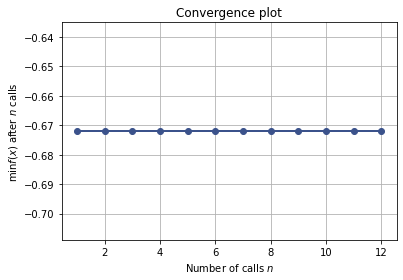

In [27]:
%%time



N_CALLS = 11

# res_gp = forest_minimize(
#     train_function,
#     space,
#     base_estimator="RF",
#     random_state=0,
#     verbose=1,
#     n_calls=11,
#     n_random_starts=10,
#     n_jobs=n_jobs,
# )


results = pd.read_csv("../data/optimization_pipeline.csv").sort_values("score")
x0 = list(results.drop(["iteration", "score"], 1).iloc[0].values)
y0 = results["score"].iloc[0]
print(y0)
par_0 = dict(zip(par_0.keys(), x0))


res_gp = gp_minimize(
    train_function,
    space,
    x0=x0,
    y0=y0,
    random_state=0,
    verbose=1,
    n_calls=N_CALLS,
    n_random_starts=10,
    n_jobs=n_jobs,
)

# res_gp = forest_minimize(
#     train_function,
#     space,
#     x0=x0,
#     y0=y0,
#     base_estimator="RF",
#     random_state=0,
#     verbose=1,
#     n_calls=N_CALLS,
#     n_random_starts=10,
#     n_jobs=n_jobs,
# )

xgb_best_params = res_gp.x

print(f"Best found params: {xgb_best_params}")

plot_convergence(res_gp)

results = (
    pd.DataFrame(res_gp.x_iters, columns=PARAMETER_NAMES)
    .assign(score=res_gp.func_vals)
    .reset_index()
    .rename(columns={"index": "iteration"})
    .sort_values("score")
)

# results.to_csv("../data/optimization_pipeline.csv", index=False, mode='a',header=False)

display(results)

In [25]:
results.to_csv("../data/optimization_pipeline.csv", index=False, mode='a',header=False)

In [15]:

results.to_csv("../data/optimization_pipeline.csv", index=False)

In [161]:

    
def func(parameters):
    learning_rate = parameters["learning_rate"]
    max_depth = parameters["max_depth"]
    min_correlation = parameters[2]

    estimator = XGBClassifier(n_jobs=n_jobs, random_state=42, eval_metric="logloss")

    min_correlation = min_correlation
    z_score_range = (-3,3)
    polynomial_degree = 1


    model = Model(
        estimator,
        classifier_params=params,
        min_correlation=min_correlation,
        z_score_range=z_score_range,
        polynomial_degree = polynomial_degree,
    )

    # model.fit(X, y)

    return model.cross_validate_score(X,y)

In [164]:
func([0.091,4,0.02])

-0.670192813380508

In [136]:
model.transform(X,y) # x+y+z+x**2+x*y+x*z+ y**2 + y*z + z**2

,var8,var4,var8*var8,var8*var4,var4*var4
id,,,,,
1,1.000000,0.750154,1.000000,0.750154,5.627312e-01
8,0.102039,0.075342,0.010412,0.007688,5.676485e-03
30,1.000000,0.031515,1.000000,0.031515,9.931948e-04
43,0.070647,0.000601,0.004991,0.000042,3.609462e-07
46,1.000000,0.749085,1.000000,0.749085,5.611277e-01
...,...,...,...,...,...
35295,0.127389,0.699662,0.016228,0.089129,4.895268e-01
35296,0.137098,0.000000,0.018796,0.000000,0.000000e+00
35301,0.137098,0.394328,0.018796,0.054062,1.554949e-01


In [58]:
model.transform(X,y)[2]

array([1.        , 0.03151499, 0.92269694])

In [62]:
0.03151499 * 0.92269694

0.0290787848371306

In [41]:
x + y + x**2 + x*y + y**2

0.0104119697656836

In [47]:
model.selected_columns

Index(['var8', 'var4'], dtype='object')

In [43]:
0.07534245**2

0.005676484772002501

In [38]:
model.transform(X,y)

array([[1.        , 0.75015412],
       [0.10203906, 0.07534245],
       [1.        , 0.03151499],
       ...,
       [0.13709798, 0.39432838],
       [0.13709798, 0.22110165],
       [0.13068922, 0.00291267]])

In [ ]:
X2 + y2 + x + y + xy

In [75]:
model.transform(X)

,var8,var4
id,,
1,-999,29442
8,17,13684
30,-999,10232
43,10,2689
46,-999,29428
...,...,...
35295,24,28766
35296,27,-999
35301,27,23761


In [62]:
min_correlation = 0.1

model.preprocessing

Pipeline(steps=[('ZClipper', ZClipper())])

In [19]:
# estimator = XGBClassifier(
#     n_jobs=n_jobs,
#     random_state=42,
    
# )

# model = Model(estimator,classifier_params={"learning_rate": 0.2, "max_depth": 3})

# model.fit(train.drop("y", 1), train["y"])

# model.cross_validate_score(train.drop("y", 1), train["y"])

[00:23:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:23:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

-0.6657156504798813

In [76]:
temp.index

RangeIndex(start=0, stop=14123, step=1)

In [77]:
validation_index

array([    2,     3,     4, ..., 14102, 14114, 14120])

In [79]:
# for fold_index in range(5):
fold_index = 0
if True:
    train_index, validation_index = stratified_folds[fold_index]
    #temp.loc[train[temp.index.isin(validation_index)].index, "fold"] = fold_index

In [83]:
train[temp.index.isin(validation_index)].index

Int64Index([   30,    43,    46,    69,   149,   160,   242,   244,   286,
              298,
            ...
            35115, 35125, 35127, 35151, 35156, 35159, 35228, 35236, 35279,
            35301],
           dtype='int64', name='id', length=2825)

In [72]:
stratified_folds[0]

(array([    0,     1,     5, ..., 14119, 14121, 14122]),
 array([    2,     3,     4, ..., 14102, 14114, 14120]))

In [91]:
# cross_validate_score(train.drop("y",1),train["y"],estimator=model.classifier,n_folds=5)

# XGBoost - Tree Based Optimisation + LR Decay  
#### In this notebook I won't get in to the details of the dataset(dealing with missing data, preprocessing and so on), since my objective here is to share a hyper parameter tuning technique and to demonstrate on how to apply learning rate decay on XGBoost training.  
#### If it does help you in any way, please upvote!  
Feel free to connect with me on [LinkedIn](https://www.linkedin.com/in/gabriel-tardochi-salles-a1653a193/).

In [17]:
import pickle
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook, tqdm

from skopt import forest_minimize
from skopt.plots import plot_convergence

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold

import xgboost
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None

In [18]:
from sklearn.metrics import f1_score, make_scorer

In [19]:
from multiprocessing import cpu_count

n_jobs = cpu_count()

### Reading data from Porto Seguro Data Challenge 2021

In [15]:
inp_path = 'data/'
metadata = pd.read_csv(inp_path + 'metadata.csv')
test = pd.read_csv(inp_path + 'test.csv')
train = pd.read_csv(inp_path + 'train.csv')
train = train.sample(frac=1, random_state=0).reset_index(drop=True)  # shuffling dataset
sub = pd.read_csv(inp_path + 'submission_sample.csv')



# train = pd.read_csv('train_1.csv')
# train_2 = pd.read_csv('train_2.csv')
# test = pd.read_csv('test_1.csv')
# test_2 = pd.read_csv('test_2.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/metadata.csv'

In [13]:
test

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68
0,0,5,126,1353,28956,743,1289,27,-999,1,33,4530,914,991,19,1,3,3,3,1155,19,1031,5,3,2,3,7,0,25,4,1,0,11,2,62,413,27,0,0,4,6,3,24,3,1,0,0,0,0,0,0,0,44,1,1,0.217528,0.272,0.367742,0.062900,0.201839,0.353965,0.166641,0.049108,0.986882,0.016683,-999.0,-999.0,0.176471,0.253676
1,2,6,126,1446,7803,5151,935,35,-999,3,63,8731,1341,2033,26,58,58,22,5,1299,26,773,5,3,1,2,1,0,25,4,0,1,6,5,58,692,21,15,8,4,0,1,30,0,1,0,0,0,0,0,0,0,13,1,1,0.221968,0.853,0.053763,0.177047,0.072127,0.074555,0.217009,0.144403,0.892028,0.038323,-999.0,-999.0,0.147059,0.099265
2,4,5,44,243,4325,1109,1903,33,24,1,63,10131,914,1503,24,60,61,23,5,1294,24,1562,5,4,1,0,1,0,26,5,2,0,17,0,12,553,0,18,0,4,10,3,26,14,1,0,0,0,0,0,0,0,36,1,1,0.213224,0.632,0.101075,0.210879,0.324770,0.384992,0.330680,0.072864,0.930373,0.021052,-999.0,-999.0,0.294118,0.136029
3,7,4,53,419,743,7750,183,35,-999,3,14,636,5879,146,26,22,22,10,4,811,26,152,5,3,2,4,4,0,24,4,2,0,12,5,38,662,28,1,0,4,9,3,28,7,1,0,0,0,0,0,1,0,13,1,1,0.205044,0.117,0.935484,0.007068,0.131070,-999.000000,0.244936,0.158088,0.986882,0.022649,-999.0,-999.0,0.294118,0.220588
4,15,4,126,1863,22693,5625,965,9,-999,3,63,24967,4427,772,5,73,73,29,5,595,5,796,0,1,0,1,7,0,11,2,1,0,21,3,18,546,0,1,0,4,6,3,28,8,1,0,0,0,0,1,0,0,51,1,1,0.203750,0.079,0.967742,0.024989,0.225166,0.059940,0.252794,0.080405,0.944501,0.021806,-999.0,-999.0,0.352941,0.113971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21178,35297,4,126,1460,13335,9048,620,35,27,3,63,13567,2617,572,26,37,35,11,4,1573,26,592,5,3,2,1,1,0,24,4,1,0,21,6,42,332,21,20,9,1,11,3,25,13,1,0,0,0,0,0,0,0,34,2,2,0.213106,0.065,0.967742,0.387701,0.148933,-999.000000,0.326307,0.132833,0.968718,0.039626,-999.0,-999.0,0.323529,0.253676
21179,35298,18,19,532,14837,2590,855,27,20,3,63,15367,2261,678,19,-999,-999,-999,-999,1383,19,700,0,3,2,1,-999,0,25,4,1,0,20,0,60,578,2,0,0,4,2,3,26,6,1,0,0,0,0,0,0,0,10,2,2,0.210435,0.740,0.101075,-999.000000,0.179243,0.205030,0.229354,0.052108,0.940464,0.016952,-999.0,-999.0,0.088235,0.209559
21180,35300,4,126,2923,16685,3162,1604,35,-999,3,63,17658,4369,1279,26,-999,-999,-999,-999,971,26,1334,5,3,0,1,-999,0,24,4,1,0,12,5,49,74,28,2,0,4,4,3,19,4,1,0,0,0,0,0,0,0,39,2,2,0.218353,0.288,0.367742,-999.000000,0.237607,0.810448,0.179781,0.029155,0.745711,0.020158,-999.0,-999.0,0.205882,0.161765
21181,35302,5,-999,-999,367,7637,1389,35,-999,3,63,28370,679,1117,26,34,34,10,4,868,26,1158,5,3,2,1,9,0,24,4,1,0,15,5,54,434,0,1,0,4,19,3,23,6,1,0,0,0,0,0,0,0,3,2,2,0.224865,0.324,0.246237,0.199008,0.102662,-999.000000,0.149598,0.032583,0.891019,0.012596,-999.0,-999.0,-999.000000,0.246324


### Building Cross Validation (Stratified)

In [5]:
# def _gen_strat_folds(df, tgt_name, n_splits=5, shuffle=True, random_state=0):
#     """ Creates Folds Inplace """
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
#     for fold, (train_index, valid_index) in enumerate(skf.split(df.drop(columns=tgt_name), df[tgt_name])):
#         df.loc[df[df.index.isin(valid_index)].index, 'fold'] = fold

# _gen_strat_folds(train, 'y')

### XGBoost Classifier Baseline

In [6]:
def generate_stratified_folds(train, n_folds=5, shuffle=True, random_state=42):

    temp = train.copy()

    # Instaciando o estritificador
    skf = StratifiedKFold(n_splits=n_folds, shuffle=shuffle, random_state=random_state)

    # Gerando os index com os folds
    stratified_folds = list(skf.split(X=temp.drop(columns="y"), y=temp["y"]))

    for fold_index in range(n_folds):

        train_index, validation_index = stratified_folds[fold_index]

        temp.loc[train[temp.index.isin(validation_index)].index, "fold"] = fold_index

    return temp["fold"].astype(int)



In [31]:
# from sklearn.base import TransformerMixin, BaseEstimator
# from copy import deepcopy


# def dataframe_transform(data, transformer):
#     return pd.DataFrame(
#         transformer.transform(data), columns=data.columns, index=data.index
#     )


# class Model(BaseEstimator, TransformerMixin):
#     def __init__(self, classifier):
#         self.classifier = classifier

#     def fit(self, X, y=None, **fit_params):

#         self.classifier.fit(X, y, **fit_params)

#         return self

#     def transform(self, X, y=None):
#         return X

#     def predict(self, X, threshold=0.5):
#         predict_prob = self.classifier.predict_proba(X)[:, 1]
#         condition = lambda x: x > threshold
#         vec_condition = np.vectorize(condition)
#         return np.where(vec_condition(predict_prob), 1, 0)

#     def predict_proba(self, X):
#         return self.classifier.predict_proba(X)[:, 1]

#     def cross_validate_score(
#         self, X, y, n_folds=5, threshold=0.3, random_state=42, verbose=0, fit_params={}
#     ):
#         return cross_validate_score(
#             X=X,
#             y=y,
#             estimator = self.classifier,
#             n_folds=n_folds,
#             scoring=f1_score,
#             threshold=0.3,
#             random_state=42,
#             verbose=0,
#             fit_params = {}
#         )


# estimator = XGBClassifier(n_jobs=n_jobs, random_state=42)

# model = Model(estimator)

In [ ]:
model.fit()

In [38]:
def cross_validate_score(
    X,
    y,
    estimator,
    n_folds=5,
    scoring=f1_score,
    threshold=0.3,
    random_state=42,
    verbose=0,
    fit_params = {}
):

    scores = []

    # estimator = XGBClassifier(
    #    n_jobs=n_jobs,
    #    random_state=random_state,
    # )

    temp = X.assign(y=y)

    temp["fold"] = generate_stratified_folds(temp, n_folds=n_folds)

    iterator = (
        range(n_folds) if verbose < 1 else tqdm(range(n_folds), desc="Cross validation")
    )

    for fold in iterator:

        # Separando os dados de treinamento para essa fold
        train_data = temp[temp["fold"] != fold].copy()

        # Separando os dados de teste para esse fold
        test_data = temp[temp["fold"] == fold].copy()

        X_train = train_data.drop(columns=["fold", "y"]).values

        X_test = test_data.drop(columns=["fold", "y"]).values

        y_train = train_data["y"].values

        y_test = test_data["y"].values
        
        fit_params["eval_set"] = [(X_test, y_test)]

        estimator.fit(X_train, y_train, **fit_params)

        prob_test = estimator.predict_proba(X_test)[:, -1]

        scores.append(scoring(y_test, prob_test > threshold))

    avg_score = np.mean(scores)
    
    return -avg_score


In [7]:
# scores = []
# xgb = XGBClassifier(
#     n_jobs=n_jobs,
#     random_state=42,
# )


# from sklearn.metrics import roc_auc_score,f1_score

# threshold = 0.3

# def custom_f1_score(prob, dtrain):
    
#     labels = dtrain.get_label()
    
#     preds = prob > threshold
#     f1 = f1_score(labels, preds)
    
#     return ("f1_score", f1)

# for fold in tqdm(range(5), desc="Cross validation progress"):

#     # Separando os dados de treinamento para essa fold
#     train_data = train[train.fold != fold].copy()

#     # Separando os dados de teste para esse fold
#     test_data = train[train.fold == fold].copy()

#     X_train = train_data.drop(columns=["fold", "y"]).values

#     X_test = test_data.drop(columns=["fold", "y"]).values

#     y_train = train_data["y"].values

#     y_test = test_data["y"].values

#     fit_params = {
#         "early_stopping_rounds": 100,
#         'eval_metric' : custom_f1_score,
#         "eval_set": [(X_test, y_test)],
#     }

#     xgb.fit(X_train, y_train, verbose=0, **fit_params)
    
# #     p = xgb.predict_proba(X_test)[:, -1]
    
# #     scores.append(f1_score(y_test, p > threshold))

# # avg_score = np.mean(scores)
# # print(f"Baseline auc = {round(avg_score, 4)}")

## Tree Based Optimisation (RF)

In [8]:

from skopt.utils import use_named_args

fit_params = {
    "early_stopping_rounds": 100,
    "eval_metric": "auc",
}

# random_state = 42
# threshold = 0.3
# n_folds = 5
# threshold = 0.3
# verbose = 0

def cross_validate_score(
    X,
    y,
    estimator,
    n_folds=5,
    scoring=f1_score,
    threshold=0.3,
    random_state=42,
    verbose=0,
    fit_params = {}
):

    scores = []

    # estimator = XGBClassifier(
    #    n_jobs=n_jobs,
    #    random_state=random_state,
    # )

    temp = X.assign(y=y)

    temp["fold"] = generate_stratified_folds(temp, n_folds=n_folds)

    iterator = (
        range(n_folds) if verbose < 1 else tqdm(range(n_folds), desc="Cross validation")
    )

    for fold in iterator:

        # Separando os dados de treinamento para essa fold
        train_data = temp[temp["fold"] != fold].copy()

        # Separando os dados de teste para esse fold
        test_data = temp[temp["fold"] == fold].copy()

        X_train = train_data.drop(columns=["fold", "y"]).values

        X_test = test_data.drop(columns=["fold", "y"]).values

        y_train = train_data["y"].values

        y_test = test_data["y"].values
        
        fit_params["eval_set"] = [(X_test, y_test)]

        estimator.fit(X_train, y_train, **fit_params)

        prob_test = estimator.predict_proba(X_test)[:, -1]

        scores.append(scoring(y_test, prob_test > threshold))

    avg_score = np.mean(scores)
    
    return -avg_score


# estimator = XGBClassifier(
#     n_jobs=n_jobs,
#     random_state=42,
#     **dict(zip(parameter_names,[0.5,3,3,0.1,0.5,2]))
# )

# fit_params = {
#     "early_stopping_rounds": 100,
#     "eval_metric": "auc",
#     "verbose": 0,
# }

# avg_score = cross_validate_score(
#     X = train.drop("y",1),
#     y = train["y"],
#     estimator = estimator,
#     fit_params = fit_params,
#     n_folds=5,
#     scoring=f1_score,
#     threshold=0.38,
#     random_state=42,
#     verbose=1,
# )


# print(f"Baseline F1 = {round(avg_score, 4)}")

In [9]:
# pd.read_csv("data/optimization.csv")

In [10]:
# (base_score=0.5, booster='gbtree', colsample_bylevel=1,
#               colsample_bynode=1, colsample_bytree=0.5470708466798732, gamma=0,
#               gpu_id=-1, importance_type='gain', interaction_constraints='',
#               learning_rate=0.03990037419687873, max_delta_step=3, max_depth=6,
#               min_child_weight=7, missing=nan, monotone_constraints='()',
#               n_estimators=34, n_jobs=16, num_parallel_tree=1, random_state=42,
#               reg_alpha=0.21369037837568203, reg_lambda=0.46481769661337713,
#               scale_pos_weight=1, subsample=1, tree_method='exact',
#               validate_parameters=1, verbosity=None)

In [68]:
par_0 = dict(zip(par.keys(),x0))
par_0["subsample"]

0.3973551645822644

In [83]:
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize


EARLY_STOPPING_ROUNDS = 100
EVAL_METRIC = "auc"
VERBOSE = 0
RANDOM_STATE = 42
N_FOLDS = 5
SCORING = f1_score
THRESHOLD = 0.35


# space = [
#     (0.018,0.024, 'uniform'),  # learning_rate
#     (65,85),                     # n_estimators
#     [12,13,14],                  # max_depth
#     (0.78,0.82),                      # subsample
#     (0.0.5, 2., 'log-uniform'),  # min_child_weight
#     (0.1, 0.4, 'log-uniform'),      # reg_alpha
#     (0.2, 0.8, 'log-uniform'),    # reg_lambda
#     (0.2, 1.0),                   # colsample_bynode
#     (0.5, 0.8),                   # colsample_bytree
#     [1, 2, 3],                    # num_parallel_tree
#     (1,5),                        # max_delta_step
# ]

# space = [
#     Real(0.0938-0.0001,0.0938+0.0001, "log-uniform", name="learning_rate"),
#     Integer(300-1, 300+1, "log-uniform",name="n_estimators"),
#     Integer(3, 4, name="max_depth",),
#     Integer(1, 2, name="num_parallel_tree"),
#     Real(1.854-0.01, 1.854+0.01, name="min_child_weight"),
#     Real(0.957 - 0.005, 0.957 + 0.005, name="reg_alpha"),
#     Real(0.724 - 0.005, 0.724 + 0.005, name="reg_lambda"),
# ]


# space = [
#     Real(0.0938-0.0001,0.0938+0.0001, "log-uniform", name="learning_rate"),
#     Integer(300-1, 300+1, "log-uniform",name="n_estimators"),
#     Integer(3, 4, name="max_depth",),
#     Integer(1, 2, name="num_parallel_tree"),
#     Real(1.854-0.01, 1.854+0.01, name="min_child_weight"),
#     Real(0.957 - 0.005, 0.957 + 0.005, name="reg_alpha"),
#     Real(0.724 - 0.005, 0.724 + 0.005, name="reg_lambda"),
# ]
# par = {
#     'learning_rate': 0.0938,
#     'n_estimators': 300,
#     'max_depth': 3,
#     'num_parallel_tree': 1,
#     'min_child_weight': 1.854,
#     'reg_alpha': 0.957,
#     'reg_lambda': 0.724,
# }

steps = {
    "learning_rate": 0.001,
    "n_estimators": 1,
    "max_depth": 1,
    "subsample": 0.001,
    "min_child_weight": 0.01,
    "reg_alpha": 0.001,
    "reg_lambda": 0.001,
    "colsample_bynode": 0.001,
    "colsample_bytree": 0.001,
    "num_parallel_tree": 1,
    "max_delta_step": 1,
}

results = pd.read_csv("data/optimization.csv").sort_values("score")
x0 = list(results.drop(["iteration", "score"], 1).iloc[0].values)
y0 = results["score"].iloc[0]
print(y0)
par_0 = dict(zip(par.keys(), x0))

space = [
    Real(
        par_0["learning_rate"] - steps["learning_rate"],
        par_0["learning_rate"] + steps["learning_rate"],
        "log-uniform",
        name="learning_rate",
    ),
    Integer(
        int(par_0["n_estimators"]) - steps["n_estimators"],
        int(par_0["n_estimators"]) + steps["n_estimators"],
        "log-uniform",
        name="n_estimators",
    ),
    Integer(
        int(par_0["max_depth"]),
        int(par_0["max_depth"] + steps["max_depth"]),
        name="max_depth",
    ),
    Real(
        par_0["subsample"] - steps["subsample"],
        par_0["subsample"] + steps["subsample"],
        name="subsample",
    ),
    Real(
        par_0["min_child_weight"] - steps["min_child_weight"],
        par_0["min_child_weight"] + steps["min_child_weight"],
        name="min_child_weight",
    ),
    Real(
        par_0["reg_alpha"] - steps["reg_alpha"],
        par_0["reg_alpha"] + steps["reg_alpha"],
        name="reg_alpha",
    ),
    Real(
        par_0["reg_lambda"] - steps["reg_lambda"],
        par_0["reg_lambda"] + steps["reg_lambda"],
        name="reg_lambda",
    ),
    Real(
        par_0["colsample_bynode"] - steps["colsample_bynode"],
        par_0["colsample_bynode"] + steps["colsample_bynode"],
        name="colsample_bynode",
    ),
    Real(
        par_0["colsample_bytree"] - steps["colsample_bytree"],
        par_0["colsample_bytree"] + steps["colsample_bytree"],
        name="colsample_bytree",
    ),
    Integer(
        int(par_0["num_parallel_tree"]),
        int(par_0["num_parallel_tree"] + steps["num_parallel_tree"]),
        name="num_parallel_tree",
    ),
    Integer(
        int(par_0["max_delta_step"]),
        int(par_0["max_delta_step"] + steps["max_delta_step"]),
        name="max_delta_step",
    ),
]

# # guardar isso de norte
# par = {
#     "learning_rate": 0.091,
#     "n_estimators": 150,
#     "max_depth": 4,
#     "subsample": 0.4,
#     "min_child_weight": 2,
#     "reg_alpha": 0.2,
#     "reg_lambda": 0.7,
#     "colsample_bynode": 0.4,
#     "colsample_bytree": 0.6,
#     "num_parallel_tree": 3,
#     "max_delta_step": 3,
# }

PARAMETER_NAMES = [elem.name for elem in space]


@use_named_args(space)
def train_function(**params):

    print(f"Testing parameters: {params.values()}")

    #     estimator = XGBClassifier(
    #         n_jobs=n_jobs, random_state=RANDOM_STATE, **dict(zip(PARAMETER_NAMES, params))
    #     )
    estimator = XGBClassifier(n_jobs=n_jobs, random_state=RANDOM_STATE, **params)

    fit_params = {
        "early_stopping_rounds": EARLY_STOPPING_ROUNDS,
        "eval_metric": EVAL_METRIC,
        "verbose": VERBOSE,
    }

    return cross_validate_score(
        X=train.drop("y", 1),
        y=train["y"],
        estimator=estimator,
        fit_params=fit_params,
        n_folds=N_FOLDS,
        scoring=SCORING,
        threshold=THRESHOLD,
        random_state=RANDOM_STATE,
        verbose=0,
    )

-0.673868815358599


In [43]:
list(par.values())

[0.091, 150, 4, 0.4, 2, 0.2, 0.7, 0.4, 0.6, 3, 3]

In [ ]:
# guardar isso de norte
par = {
    "learning_rate": 0.091,
    "n_estimators": 150,
    "max_depth": 4,
    "subsample": 0.4,
    "min_child_weight": 2,
    "reg_alpha": 0.2,
    "reg_lambda": 0.7,
    "colsample_bynode": 0.4,
    "colsample_bytree": 0.6,
    "num_parallel_tree": 3,
    "max_delta_step": 3,
}


In [77]:
# estimator = XGBClassifier(
#     n_jobs=n_jobs,  random_state=RANDOM_STATE, **par
# )

# fit_params = {
#     "early_stopping_rounds": EARLY_STOPPING_ROUNDS,
#     "eval_metric": EVAL_METRIC,
#     "verbose": VERBOSE,
# }

# cross_validate_score(
#     X=train.drop("y", 1),
#     y=train["y"],
#     estimator=estimator,
#     fit_params=fit_params,
#     n_folds=N_FOLDS,
#     scoring=SCORING,
#     threshold=THRESHOLD,
#     random_state=RANDOM_STATE,
#     verbose=0,
# )

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0003
Function value obtained: -0.6739
Current minimum: -0.6739
Iteration No: 2 started. Evaluating function at random point.
Testing parameters: dict_values([0.09533046831331038, 154, 5, 0.39789785307356307, 2.014941475958356, 0.1988094158759588, 0.7029824449140873, 0.39845942912964327, 0.599224432765673, 4, 4])
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.2573
Function value obtained: -0.6675
Current minimum: -0.6739
Iteration No: 3 started. Evaluating function at random point.
Testing parameters: dict_values([0.09510456469167776, 153, 5, 0.39687814191682935, 2.0154336394636605, 0.1987771355410545, 0.7043016860189045, 0.39862670473583367, 0.6004192946932296, 4, 4])
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.9128
Function value obtained: -0.6663
Current minimum: -0.6739
Iteration No: 4 started. Evaluating

,iteration,learning_rate,n_estimators,max_depth,subsample,min_child_weight,reg_alpha,reg_lambda,colsample_bynode,colsample_bytree,num_parallel_tree,max_delta_step,score
0,0,0.095150,153.0,4.0,0.397203,2.012470,0.199041,0.703387,0.399346,0.599679,4.0,3.0,-0.673869
9,9,0.094314,153.0,4.0,0.397888,2.015414,0.199723,0.702917,0.399142,0.599785,4.0,3.0,-0.670507
5,5,0.095451,152.0,4.0,0.397705,2.014627,0.198691,0.702464,0.399615,0.600597,5.0,4.0,-0.669532
8,8,0.094864,153.0,5.0,0.397964,2.020835,0.198474,0.703518,0.400076,0.599697,5.0,4.0,-0.669216
4,4,0.094418,153.0,4.0,0.396648,2.010200,0.199846,0.703287,0.399572,0.600484,4.0,4.0,-0.669123
3,3,0.095186,153.0,5.0,0.397367,2.013218,0.199558,0.702599,0.399293,0.599052,5.0,3.0,-0.668750
6,6,0.096140,153.0,4.0,0.397153,2.014940,0.198717,0.703737,0.398980,0.600236,5.0,4.0,-0.668190
1,1,0.095330,154.0,5.0,0.397898,2.014941,0.198809,0.702982,0.398459,0.599224,4.0,4.0,-0.667464
10,10,0.094440,153.0,5.0,0.396780,2.011136,0.199553,0.703180,0.400138,0.599957,5.0,4.0,-0.666865
7,7,0.094177,153.0,5.0,0.398147,2.020034,0.199060,0.702499,0.399248,0.598719,4.0,4.0,-0.666663


CPU times: user 16min 15s, sys: 3.33 s, total: 16min 18s
Wall time: 1min 7s


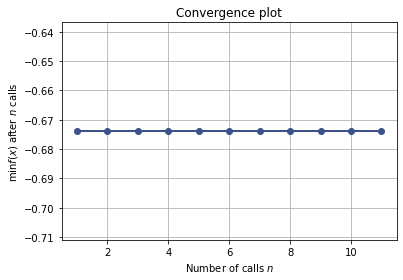

In [84]:
%%time

from skopt.utils import use_named_args

N_CALLS = 10
# res_gp = forest_minimize(
#     train_function,
#     space,
#     base_estimator="RF",
#     random_state=0,
#     verbose=1,
#     n_calls=11,
#     n_random_starts=10,
#     n_jobs=n_jobs,
# )


results = pd.read_csv("data/optimization.csv").sort_values('score')
x0 = list(results.drop(["iteration", "score"], 1).iloc[0].values)
y0 = results["score"].iloc[0]


res_gp = gp_minimize(
    train_function,
    space,
    x0=x0,
    y0=y0,
    random_state=0,
    verbose=1,
    n_calls=N_CALLS,
    n_random_starts=10,
    n_jobs=n_jobs,
)

xgb_best_params = res_gp.x

print(f"Best found params: {xgb_best_params}")

plot_convergence(res_gp)

results = (
    pd.DataFrame(res_gp.x_iters, columns=PARAMETER_NAMES)
    .assign(score=res_gp.func_vals)
    .reset_index()
    .rename(columns={"index": "iteration"})
    .sort_values("score")
)

results.to_csv("data/optimization.csv", index=False, mode='a',header=False)

display(results)

In [113]:
# results

In [85]:
results = pd.read_csv("data/optimization.csv").sort_values("score")
x0 = list(results.drop(["iteration", "score"], 1).iloc[0].values)
y0 = results["score"].iloc[0]


params = dict(zip(PARAMETER_NAMES, x0))

for col in ["n_estimators", "max_depth", "num_parallel_tree"]:    
    if col in params:
        params[col] = int(params[col])


estimator = XGBClassifier(n_jobs=n_jobs, random_state=RANDOM_STATE, **params)

fit_params = {
    "early_stopping_rounds": EARLY_STOPPING_ROUNDS,
    "eval_metric": EVAL_METRIC,
    "verbose": VERBOSE,
}

cross_validate_score(
    X=train.drop("y", 1),
    y=train["y"],
    estimator=estimator,
    fit_params=fit_params,
    n_folds=N_FOLDS,
    scoring=SCORING,
    threshold=THRESHOLD,
    random_state=RANDOM_STATE,
    verbose=0,
)

-0.673868815358599

In [97]:
def predict(model, X_test, threshold=0.5):
    predict_prob = model.predict_proba(X_test)[:, 1]
    condition = lambda x: x > threshold
    vec_condition = np.vectorize(condition)
    return np.where(vec_condition(predict_prob), 1.0, 0.0)

estimator.fit(X=train.drop("y", 1), y=train["y"])



y_pred = predict(estimator, test, threshold=THRESHOLD).astype(int)

pd.read_csv("submission-12.csv")[["id"]].assign(predicted=y_pred).to_csv("submission-14.csv", index=False)

[23:42:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [93]:
test

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68
0,0,5,126,1353,28956,743,1289,27,-999,1,33,4530,914,991,19,1,3,3,3,1155,19,1031,5,3,2,3,7,0,25,4,1,0,11,2,62,413,27,0,0,4,6,3,24,3,1,0,0,0,0,0,0,0,44,1,1,0.217528,0.272,0.367742,0.062900,0.201839,0.353965,0.166641,0.049108,0.986882,0.016683,-999.0,-999.0,0.176471,0.253676
1,2,6,126,1446,7803,5151,935,35,-999,3,63,8731,1341,2033,26,58,58,22,5,1299,26,773,5,3,1,2,1,0,25,4,0,1,6,5,58,692,21,15,8,4,0,1,30,0,1,0,0,0,0,0,0,0,13,1,1,0.221968,0.853,0.053763,0.177047,0.072127,0.074555,0.217009,0.144403,0.892028,0.038323,-999.0,-999.0,0.147059,0.099265
2,4,5,44,243,4325,1109,1903,33,24,1,63,10131,914,1503,24,60,61,23,5,1294,24,1562,5,4,1,0,1,0,26,5,2,0,17,0,12,553,0,18,0,4,10,3,26,14,1,0,0,0,0,0,0,0,36,1,1,0.213224,0.632,0.101075,0.210879,0.324770,0.384992,0.330680,0.072864,0.930373,0.021052,-999.0,-999.0,0.294118,0.136029
3,7,4,53,419,743,7750,183,35,-999,3,14,636,5879,146,26,22,22,10,4,811,26,152,5,3,2,4,4,0,24,4,2,0,12,5,38,662,28,1,0,4,9,3,28,7,1,0,0,0,0,0,1,0,13,1,1,0.205044,0.117,0.935484,0.007068,0.131070,-999.000000,0.244936,0.158088,0.986882,0.022649,-999.0,-999.0,0.294118,0.220588
4,15,4,126,1863,22693,5625,965,9,-999,3,63,24967,4427,772,5,73,73,29,5,595,5,796,0,1,0,1,7,0,11,2,1,0,21,3,18,546,0,1,0,4,6,3,28,8,1,0,0,0,0,1,0,0,51,1,1,0.203750,0.079,0.967742,0.024989,0.225166,0.059940,0.252794,0.080405,0.944501,0.021806,-999.0,-999.0,0.352941,0.113971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21178,35297,4,126,1460,13335,9048,620,35,27,3,63,13567,2617,572,26,37,35,11,4,1573,26,592,5,3,2,1,1,0,24,4,1,0,21,6,42,332,21,20,9,1,11,3,25,13,1,0,0,0,0,0,0,0,34,2,2,0.213106,0.065,0.967742,0.387701,0.148933,-999.000000,0.326307,0.132833,0.968718,0.039626,-999.0,-999.0,0.323529,0.253676
21179,35298,18,19,532,14837,2590,855,27,20,3,63,15367,2261,678,19,-999,-999,-999,-999,1383,19,700,0,3,2,1,-999,0,25,4,1,0,20,0,60,578,2,0,0,4,2,3,26,6,1,0,0,0,0,0,0,0,10,2,2,0.210435,0.740,0.101075,-999.000000,0.179243,0.205030,0.229354,0.052108,0.940464,0.016952,-999.0,-999.0,0.088235,0.209559
21180,35300,4,126,2923,16685,3162,1604,35,-999,3,63,17658,4369,1279,26,-999,-999,-999,-999,971,26,1334,5,3,0,1,-999,0,24,4,1,0,12,5,49,74,28,2,0,4,4,3,19,4,1,0,0,0,0,0,0,0,39,2,2,0.218353,0.288,0.367742,-999.000000,0.237607,0.810448,0.179781,0.029155,0.745711,0.020158,-999.0,-999.0,0.205882,0.161765
21181,35302,5,-999,-999,367,7637,1389,35,-999,3,63,28370,679,1117,26,34,34,10,4,868,26,1158,5,3,2,1,9,0,24,4,1,0,15,5,54,434,0,1,0,4,19,3,23,6,1,0,0,0,0,0,0,0,3,2,2,0.224865,0.324,0.246237,0.199008,0.102662,-999.000000,0.149598,0.032583,0.891019,0.012596,-999.0,-999.0,-999.000000,0.246324


In [83]:
y_pred = estimator.predict(test.drop("y", 1)).astype(int)


pd.read_csv("submission-12.csv")[["id"]].assign(predicted=y_pred).to_csv("submission-13.csv", index=False)

In [110]:
# def train_func(params):
#     """ training funcion that will be optimised """
#     learning_rate = params[0]
#     max_depth = params[1]
#     min_child_weight=params[2]
#     subsample = params[3]
#     colsample_bynode = params[4]
#     num_parallel_tree = params[5]
#     print(f"Testing parameters: {params}")
    
#     scores = []
#     for fold in range(5):
#         train_data = train[train.fold != fold].copy()
#         test_data = train[train.fold == fold].copy()
#         X_train = train_data.drop(columns=['fold', 'y']).values
#         X_test = test_data.drop(columns=['fold', 'y']).values
#         y_train = train_data['y'].values
#         y_test = test_data['y'].values

        
#         fit_params = {
#             'early_stopping_rounds': 100,
#             'eval_metric' : 'auc',
#             'eval_set': [(X_test, y_test)],
#             'verbose': False,
#         }

#         xgb = XGBClassifier(
#             n_jobs=-1,
#             eval_metric='auc',
#             random_state=0,
#             n_estimators=100,  # you should tune n_estimators aswell
#             learning_rate=learning_rate,
#             max_depth=max_depth,
#             min_child_weight=min_child_weight,
#             subsample=subsample,
#             colsample_bynode=colsample_bynode,
#             num_parallel_tree=num_parallel_tree
#         )
        
#         xgb.fit(X_train, y_train, **fit_params)
#         p = xgb.predict_proba(X_test)[:, -1]
#         scores.append(metrics.roc_auc_score(y_test, p))
        
#     avg_score = np.mean(scores)
#     return -avg_score  # metric that will be minimized, since a bigger auc is better, we negate it

# space = [
#     (1e-3, 9e-1, 'log-uniform'),  # learning_rate
#     (3, 30),  # max_depth
#     (0.01, 20.0, 'log-uniform'),  # min_child_weight
#     (0.2, 1.0),  # subsample
#     (0.2, 1.0),  # colsample_bynode
#     [1, 2, 3],  # num_parallel_tree
# ]

# res_gp = forest_minimize(train_func, space, base_estimator='RF', random_state=0, verbose=1, n_calls=50, n_random_starts=10)
# xgb_best_params = res_gp.x
# print(f"Best found params: {xgb_best_params}") 
# plot_convergence(res_gp);

## Applying learning rate decay

In [108]:
# setting the best found LR as base
def xgb_learning_rate_decay_power_099(boosting_round, num_boost_round):
    base_learning_rate = xgb_best_params[0]
    lr = base_learning_rate  * np.power(.99, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_decay_power_0995(boosting_round, num_boost_round):
    base_learning_rate = xgb_best_params[0]
    lr = base_learning_rate  * np.power(.995, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_decay_power_095(boosting_round, num_boost_round):
    base_learning_rate = xgb_best_params[0]
    lr = base_learning_rate  * np.power(.95, boosting_round)
    return lr if lr > 1e-3 else 1e-3

# testing some default values
def xgb_learning_rate_010_decay_power_099(boosting_round, num_boost_round):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_010_decay_power_0995(boosting_round, num_boost_round):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_010_decay_power_095(boosting_round, num_boost_round):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.95, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_050_decay_power_099(boosting_round, num_boost_round):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_050_decay_power_0995(boosting_round, num_boost_round):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.995, boosting_round)
    return lr if lr > 1e-3 else 1e-3

def xgb_learning_rate_050_decay_power_095(boosting_round, num_boost_round):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.95, boosting_round)
    return lr if lr > 1e-3 else 1e-3

In [123]:
poss_cbs = {
    0: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_099)],
    1: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_0995)],
    2: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_095)],
    3: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_099)],
    4: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_0995)],
    5: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_095)],
    6: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_099)],
    7: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_0995)],
    8: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_095)],
}

results = pd.read_csv("data/optimization.csv").sort_values("score")
x0 = list(results.drop(["iteration", "score"], 1).iloc[0].values)
y0 = results["score"].iloc[0]

params = dict(zip(PARAMETER_NAMES, x0))

for col in ["n_estimators", "max_depth", "num_parallel_tree"]:
    if col in params:
        params[col] = int(params[col])

estimator = XGBClassifier(n_jobs=n_jobs, random_state=RANDOM_STATE, **params)

fit_params = {
    "early_stopping_rounds": EARLY_STOPPING_ROUNDS,
    "eval_metric": EVAL_METRIC,
    "verbose": VERBOSE,
    "callbacks": poss_cbs[8],
}

cross_validate_score(
    X=train.drop("y", 1),
    y=train["y"],
    estimator=estimator,
    fit_params=fit_params,
    n_folds=N_FOLDS,
    scoring=SCORING,
    threshold=THRESHOLD,
    random_state=RANDOM_STATE,
    verbose=0,
)

-0.6193136536010251

In [7]:
# could have been a part of the hyper parameter search, but here I will be tuning it only for the best model 
learning_rate = xgb_best_params[0]
max_depth = xgb_best_params[1]
min_child_weight = xgb_best_params[2]
subsample = xgb_best_params[3]
colsample_bynode = xgb_best_params[4]
num_parallel_tree = xgb_best_params[5]

poss_cbs = {
    0: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_099)],
    1: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_0995)],
    2: [xgboost.callback.reset_learning_rate(xgb_learning_rate_decay_power_095)],
    3: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_099)],
    4: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_0995)],
    5: [xgboost.callback.reset_learning_rate(xgb_learning_rate_010_decay_power_095)],
    6: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_099)],
    7: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_0995)],
    8: [xgboost.callback.reset_learning_rate(xgb_learning_rate_050_decay_power_095)]
}

# trying different lr decay callbacks
best_cb = None
best_score = 0
for cb in poss_cbs:
    scores = []
    for fold in range(5):
        train_data = train[train.fold != fold].copy()
        test_data = train[train.fold == fold].copy()
        X_train = train_data.drop(columns=['fold', 'y']).values
        X_test = test_data.drop(columns=['fold', 'y']).values
        y_train = train_data['y'].values
        y_test = test_data['y'].values

        fit_params = {
            'early_stopping_rounds': 1000,
            'eval_metric' : 'auc',
            'eval_set': [(X_test, y_test)],
            'callbacks': poss_cbs[cb],
            'verbose': False,
        }

        xgb = XGBClassifier(
            n_jobs=-1,
            eval_metric='auc',
            random_state=0,
            n_estimators=100,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bynode=colsample_bynode,
            num_parallel_tree=num_parallel_tree
        )

        xgb.fit(X_train, y_train, **fit_params)
        p = xgb.predict_proba(X_test)[:, -1]
        scores.append(metrics.roc_auc_score(y_test, p))
    avg_score = np.mean(scores)
    print(f"Callback: {cb}, auc = {round(avg_score, 4)}")
    if avg_score > best_score:
        best_score = avg_score
        best_cb = cb

Callback: 0, auc = 0.8893
Callback: 1, auc = 0.8891
Callback: 2, auc = 0.8855
Callback: 3, auc = 0.8832
Callback: 4, auc = 0.8852
Callback: 5, auc = 0.8675
Callback: 6, auc = 0.873
Callback: 7, auc = 0.876
Callback: 8, auc = 0.8621


## Finding the best threshold

In [8]:
cross_val_probas = []
ground_truths = []
for fold in range(5):
    train_data = train[train.fold != fold].copy()
    test_data = train[train.fold == fold].copy()
    X_train = train_data.drop(columns=['fold', 'y']).values
    X_test = test_data.drop(columns=['fold', 'y']).values
    y_train = train_data['y'].values
    y_test = test_data['y'].values

    fit_params = {
        'early_stopping_rounds': 1000,
        'eval_metric' : 'auc',
        'eval_set': [(X_test, y_test)],
        'callbacks': poss_cbs[best_cb],
        'verbose': False,
    }

    xgb = XGBClassifier(
        n_jobs=-1,
        eval_metric='auc',
        random_state=0,
        n_estimators=100,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bynode=colsample_bynode,
        num_parallel_tree=num_parallel_tree
    )

    xgb.fit(X_train, y_train, **fit_params)
    p = xgb.predict_proba(X_test)[:, -1]
    cross_val_probas += p.tolist()
    ground_truths += y_test.tolist()

In [9]:
best_th = 0
f1_max = 0
for th in np.linspace(0.1, 0.9, num=1000):
    f1 = metrics.f1_score(np.asarray(ground_truths), (np.asarray(cross_val_probas) >= th).astype(int))
    if f1_max < f1:
        f1_max = f1
        best_th = th
print(f"MAX F1 SCORE: {f1_max}, THRESH HOLD: {best_th}")

MAX F1 SCORE: 0.6766169154228856, THRESH HOLD: 0.30340340340340344


# Final model and submission

In [10]:
train_data = train.copy()
test_data = test.copy()
X_train = train_data.drop(columns=['fold', 'y']).values
X_test = test_data.values
y_train = train_data['y'].values

fit_params = {
    'eval_metric' : 'auc',
    'callbacks': poss_cbs[best_cb],
    'verbose': False,
}

xgb = XGBClassifier(
    n_jobs=-1,
    eval_metric='auc',
    random_state=0,
    n_estimators=100,
    learning_rate=learning_rate,
    max_depth=max_depth,
    min_child_weight=min_child_weight,
    subsample=subsample,
    colsample_bynode=colsample_bynode,
    num_parallel_tree=num_parallel_tree
)

xgb.fit(X_train, y_train, **fit_params)
p = xgb.predict_proba(X_test)[:, -1]
preds = p >= best_th

In [11]:
sub['predicted'] = preds
sub.to_csv('submission.csv', index=False)
sub.head(10)

,id,predicted
0,0,True
1,2,True
2,4,False
3,7,True
4,15,True
5,26,False
6,44,True
7,45,False
8,57,True
9,66,False
